### Update 6, Part 2b - Porosity
Using the results from the spatial bootstraps of average porosity, sequential gaussian simulations are performed to create a set of realizations for porosity in the field.

In [1]:
# Import Packages/Libraries
import geostatspy.GSLIB as GSLIB          # GSLIB utilies, visualization and wrapper
import geostatspy.geostats as geostats    # GSLIB methods convert to Python 
import pandas as pd
import seaborn as sns
import numpy as np                        # set working directory, run executables
import matplotlib.pyplot as plt           # for plotting
from scipy import stats                   # summary statistics
import astropy.convolution.convolve as convolve
import scipy.signal as signal             # kernel for moving window calculation
import math                               # trig etc.
import scipy
import random

In [2]:
class Univariate():
    def __init__(self,welldata):
        self.filename = welldata # set filename
        self.welldata = pd.read_csv(welldata) # read well data into dataframe
        #self.sandstone = self.welldata.loc[(data.welldata['Facies'] == 1)] # Group by facies (Sandstone)
        #self.shale = self.welldata.loc[(data.welldata['Facies'] == 0)] # Group by facies (Shale)

        
    def comp_outliers(self,dataframe,metric):
        # computes the upper and lower fence based on Tukey 1.5 x IQR method and returns an array of format 
        # [lower_fence,upper_fence]
        P25 = np.percentile(dataframe[metric].values,25)
        P75 = np.percentile(dataframe[metric].values,75)
        lower_fence = P25 - 1.5*(P75-P25)
        upper_fence = P75 + 1.5*(P75-P25)
        if lower_fence < 0.0:
            lower_fence = 0.0
        return [lower_fence,upper_fence]
    
    def remove_outliers(self,dataframe,metric):
        # removes outliers from dataframe and returns new dataframe without outliers
        bounds = self.comp_outliers(dataframe,metric)
        cleaned_data = dataframe.loc[(dataframe[metric] >= bounds[0]) & (dataframe[metric] <= bounds[1])]
        return cleaned_data 

Load the original data

In [3]:
# load original csv file
data = Univariate('1_sample_data.csv')
# doing facies separation and outlier removal
# pulling out the raw facies data
Sandstone_raw = data.welldata.loc[(data.welldata['Facies'] == 1)]
Shale_raw = data.welldata.loc[(data.welldata['Facies'] == 0)]
# outlier removal for sandstone (porosity, permeability, acoustic impedance)
Sandstone_cleaned_por = data.remove_outliers(Sandstone_raw,'Porosity')
Sandstone_cleaned_por_perm = data.remove_outliers(Sandstone_cleaned_por,'Perm')
Sandstone_final = data.remove_outliers(Sandstone_cleaned_por_perm,'AI')
# outlier removal for shale (porosity, permeability, acoustic impedance)
Shale_cleaned_por = data.remove_outliers(Shale_raw,'Porosity')
Shale_cleaned_por_perm = data.remove_outliers(Shale_cleaned_por,'Perm')
Shale_final = data.remove_outliers(Shale_cleaned_por_perm,'AI')
# combining facies for total 'cleaned' dataset
df = pd.concat([Sandstone_final,Shale_final])
del df['Unnamed: 0']

Load the spatial bootstrapped average porosity values from part 1 of this update.

In [4]:
# load the spatial bootstrap realizations of average porosity
avg_por = np.loadtxt('spatial_porosity_avg.txt')

From part 1 of this update a model variogram was defined for the porosity field. Re-define that variogram here.

In [5]:
# define porosity model variogram from part 1 of this update
tmin = -9999.; tmax = 9999.                         # no trimming 
lag_dist = 10.0; lag_tol = 20.0; nlag = 75;         # maximum lag is 600m and tolerance = lag distance for smoothing
bandh = 9999.9; atol = 22.5                         # no bandwidth, directional variograms
isill = 1                                           # standardize sill
nug = 0.0                    # defining nugget effect
nst = 1                      # defining number of nested structures
it1 = 1;                     # defining types of model variograms
cc1 = 1.0;                   # defining contributions of each structure
azi1 = 122.5;                # defining major azimuthal direction
hmaj1 = 50;                  # defining range in major direction
hmin1 = 30;                  # defining range in minor direction

vario = GSLIB.make_variogram(nug,nst,it1,cc1,azi1,hmaj1,hmin1)

Set some parameters for the sequential gaussian simulation.

In [6]:
# setting some parameters for SGS
nx = 100; ny = 100; xsiz = 10.0; ysiz = 10.0; xmn = 5.0; ymn = 5.0; nxdis = 1; nydis = 1
ndmin = 0; ndmax = 10; radius = 800; skmean = 0

Do the sequential gaussian simulation 20 times with the underlying porosity average drawn from the spatial bootstrap results.

In [7]:
# do the SGS
numplots = 20
rand_por = np.zeros([numplots,1])
# loop
sim_sgs = np.zeros([numplots,100,100]) # preallocate array to hold simulation results
for i in range(0,numplots):
    rand_por[i] = random.choices(avg_por) # grab random average porosity from bootstrapped results
    trend = np.zeros([ny,nx])
    trend.fill(rand_por[i][0])
    sim_sgs[i,:,:] = geostats.sgsim(df,'X','Y','Porosity',wcol=-1,scol=-1,tmin=tmin,tmax=tmax,
                                itrans=1,ismooth=0,dftrans=0,tcol=0,
                                twtcol=0,zmin=0.0,zmax=0.3,ltail=1,ltpar=0.0,utail=1,utpar=0.3,nsim=1,
                                nx=nx,xmn=xmn,xsiz=xsiz,ny=ny,ymn=ymn,ysiz=ysiz,seed=i*50,
                                ndmin=ndmin,ndmax=ndmax,nodmax=20,mults=0,nmult=2,noct=-1,
                                radius=radius,radius1=1,sang1=0,
                                mxctx=10,mxcty=10,ktype=2,colocorr=0.0,sec_map=trend,vario=vario)


 Data for SGSIM: Number of acceptable data     = 217
                 Number trimmed                = 0
                 Weighted Average              = 0.1354
                 Weighted Variance             = 0.0006
                 Weighted Transformed Average  = 0.0009
                 Weighted Transformed Variance = 0.997
 Secondary Data: Number of data             = 10000
                 Equal Weighted Average     = -0.0102
                 Equal Weighted Variance    = 0.0
Setting up rotation matrices for variogram and search
Working on realization number 0
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = 0.0186 (close to 0.0?)
                                   variance 

   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = 0.0123 (close to 0.0?)
                                   variance = 0.9862 (close to gammabar(V,V)? approx. 1.0)

 Data for SGSIM: Number of acceptable data     = 217
                 Number trimmed                = 0
                 Weighted Average              = 0.1354
                 Weighted Variance             = 0.0006
                 Weighted Transformed Average  = 0.0009
                 Weighted Transformed Variance = 0.997
 Secondary Data: Number of data             = 10000
                 Equal Weighted Average     = -0.0436
                 Equal Weighted Variance    = 0.0
Setting up rotation matrices for variogram and search
Working 

   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = -0.0596 (close to 0.0?)
                                   variance = 0.9865 (close to gammabar(V,V)? approx. 1.0)

 Data for SGSIM: Number of acceptable data     = 217
                 Number trimmed                = 0
                 Weighted Average              = 0.1354
                 Weighted Variance             = 0.0006
                 Weighted Transformed Average  = 0.0009
                 Weighted Transformed Variance = 0.997
 Secondary Data: Number of data             = 10000
                 Equal Weighted Average     = -0.0167
                 Equal Weighted Variance    = 0.0
Setting up rotation matrices for variogram and search
Working

Plot all of the realizations from the sequential gaussian simulation. The correlation range from the variogram is short, so the continuity in the porosity field is short scale. The data location values should be honored however.

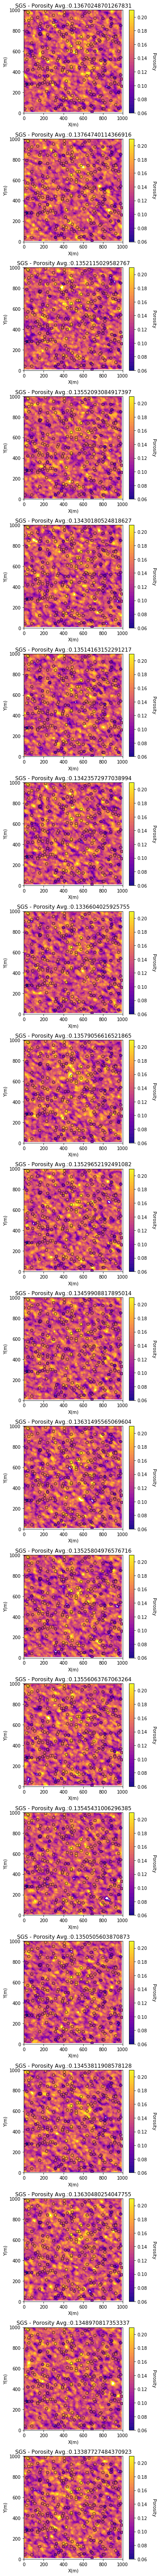

In [8]:
# plot realizations of the SGS
xmin = 0.0; xmax = 1000.0; ymin = 0.0; ymax = 1000.0; cmap = plt.cm.plasma # plotting parameters
# loop
plt.figure(figsize=(5,4*numplots))
for i in range(0,numplots):
    plt.subplot(numplots,1,i+1)
    GSLIB.locpix_st(sim_sgs[i,:,:],xmin,xmax,ymin,ymax,xsiz,0.06,0.21,df,
                    'X','Y','Porosity',
                    'SGS - Porosity Avg.:' + str(rand_por[i][0]),
                    'X(m)','Y(m)','Porosity',cmap)

plt.tight_layout()
plt.show()

Save the realizations and the porosity averages used so that they can help in the estimation of the oil in place and the uncertainty assessment.

In [9]:
# save the SGS realizations
np.save('SGS_porosity',sim_sgs)

In [10]:
# save the porosity averages used
np.save('SGS_por_avgs',rand_por)

In [11]:
P10Map = np.empty([100,100])
P50Map = np.empty([100,100])
P90Map = np.empty([100,100])

for i in range(100):
    for j in range(100):
        P10Map[i,j] = .9*20*6.29*np.percentile(sim_sgs[:,i,j], 10)
        P50Map[i,j] = .9*20*6.29*np.percentile(sim_sgs[:,i,j], 50)
        P90Map[i,j] = .9*20*6.29*np.percentile(sim_sgs[:,i,j], 90)

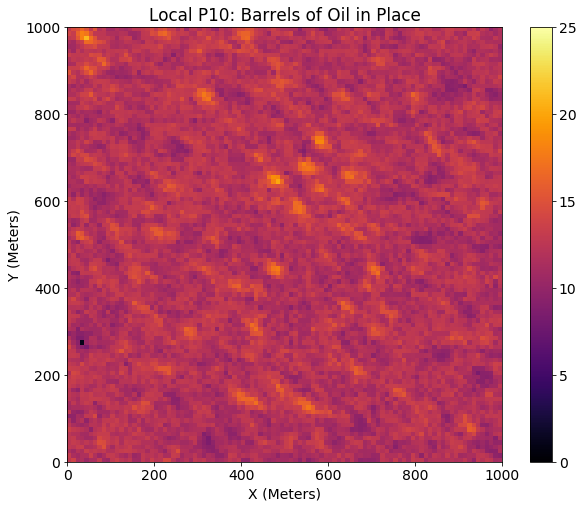

In [71]:
X,Y = np.meshgrid(df['X'].values, df['Y'].values)
P10 = plt.imshow(P10Map, cmap=plt.cm.inferno, extent=(0, 1000, 0, 1000))
plt.clim(0, 25)
plt.xlabel('X (Meters)')
plt.ylabel('Y (Meters)')
plt.title('Local P10: Barrels of Oil in Place')
plt.colorbar()
plt.rcParams.update({'font.size': 14})
fig1 = plt.gcf()
plt.show(P10)
plt.rcParams["figure.figsize"] = (10,8)
fig1.savefig('OIP-P10.png',dpi=100)


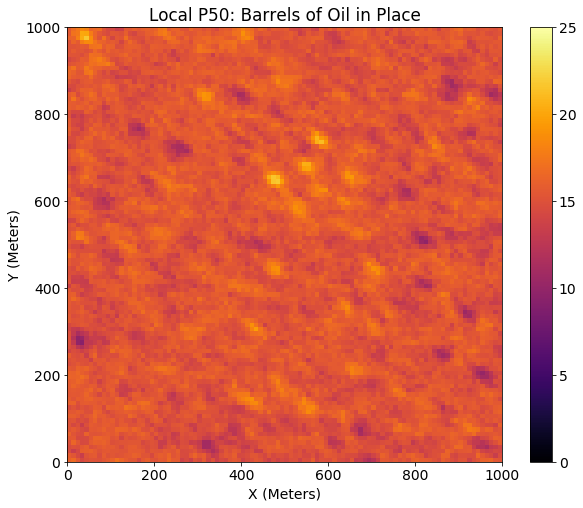

In [72]:
plt.figure()
P50 = plt.imshow(P50Map, cmap=plt.cm.inferno, extent=(0, 1000, 0, 1000))
plt.clim(0, 25)
plt.xlabel('X (Meters)')
plt.ylabel('Y (Meters)')
plt.title('Local P50: Barrels of Oil in Place')
plt.colorbar()
plt.rcParams.update({'font.size': 14})
fig1 = plt.gcf()
plt.show(P50)
plt.rcParams["figure.figsize"] = (10,8)
fig1.savefig('OIP-P50.png',dpi=100)

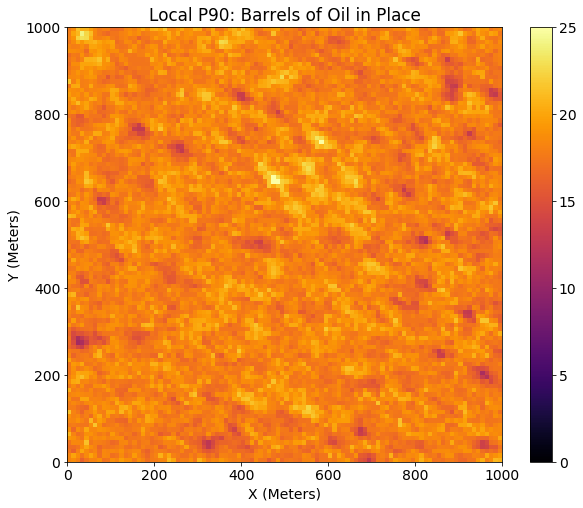

In [73]:
P90 = plt.imshow(P90Map, cmap=plt.cm.inferno, extent=(0, 1000, 0, 1000))
plt.clim(0, 25)
plt.xlabel('X (Meters)')
plt.ylabel('Y (Meters)')
plt.title('Local P90: Barrels of Oil in Place')
plt.colorbar()
plt.rcParams.update({'font.size': 14})
fig1 = plt.gcf()
plt.show(P90)
plt.rcParams["figure.figsize"] = (10,8)
fig1.savefig('OIP-P90.png',dpi=100)

In [21]:
np.percentile(dist,10)

-1.334629150134037

In [22]:
np.percentile(dist,90)

1.232735242702363

In [70]:
np.sum(P50Map)/10000

15.265665445010212